In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

fewer_sp500_tickers = [
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
]

sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]

In [2]:
import datetime
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ─── 1) PARAMETERS & TICKERS ────────────────────────────────────────────────────

start = datetime.datetime(1990, 1, 1)
end   = datetime.datetime(2019, 12, 31)

# your chosen subset of S&P500 tickers
tickers = fewer_sp500_tickers  # Make sure this is defined

# ─── 2) DOWNLOAD PRICE, VOLUME, DIVIDENDS ─────────────────────────────────────

# 2a) prices & volume
df = yf.download(tickers, start=start, end=end, auto_adjust=False)
prices = df['Close'].ffill().bfill()    # DataFrame (T, N)
vols   = df['Volume'].ffill().bfill()   # DataFrame (T, N)

# 2b) dividends series per ticker (as aligned DataFrames)
divs_dict = {}
for t in tickers:
    divs = yf.Ticker(t).dividends
    divs.index = divs.index.tz_localize(None)  # Make tz-naive
    divs = divs[start:end].astype(np.float32)
    divs_dict[t] = divs
divs_df = pd.DataFrame(divs_dict).reindex(prices.index).ffill().fillna(0.0)

# ─── 3) COMPUTE 30-DAY MA & SLOPE ───────────────────────────────────────────────

ma30 = prices.rolling(window=30).mean().ffill().bfill()  # (T, N)

# slope: linear fit over the last 30 days at each time t
slopes = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=np.float32)
for t in range(len(prices)):
    window = prices.iloc[max(0, t-29):t+1]
    x = np.arange(len(window))
    for col in prices.columns:
        y = window[col].values
        if len(y) >= 2:
            m, _ = np.polyfit(x, y, 1)
        else:
            m = 0.0
        slopes.loc[prices.index[t], col] = np.float32(m)

# convert all to NumPy arrays aligned on the same datetime index
dates       = prices.index
prices_arr  = prices.values.astype(np.float32)     # (T, N)
vols_arr    = vols.values.astype(np.float32)       # (T, N)
divs_arr    = divs_df.values.astype(np.float32)    # (T, N)
ma30_arr    = ma30.values.astype(np.float32)       # (T, N)
slopes_arr  = slopes.values.astype(np.float32)     # (T, N)

# ─── 4) DOWNLOAD MACRO SERIES FROM FRED ────────────────────────────────────────

# UNRATE = unemployment rate (%), DGS10 = 10-yr Treasury yield (%), SP500EARN = S&P500 EPS
macro = pdr.DataReader(
    ['UNRATE','DGS10'], 
    'fred', 
    start, 
    end
).reindex(dates).ffill().bfill()

unemp_arr   = macro['UNRATE'].values.astype(np.float32)    # (T,)
irate_arr   = macro['DGS10'].values.astype(np.float32)     # (T,)


[*********************100%***********************]  71 of 71 completed


In [3]:
mu_price = prices_arr.mean(axis=0);   std_price = prices_arr.std(axis=0) + 1e-6
mu_div   = divs_arr.mean(axis=0);     std_div   = divs_arr.std(axis=0) + 1e-6
mu_vol   = vols_arr.mean(axis=0);     std_vol   = vols_arr.std(axis=0) + 1e-6
mu_ma30   = ma30_arr.mean(axis=0);     std_vol   = ma30_arr.std(axis=0) + 1e-6
mu_slopes   = slopes_arr.mean(axis=0);     std_slopes   = slopes_arr.std(axis=0) + 1e-6
mu_ir    = irate_arr.mean();           std_ir    = irate_arr.std()    + 1e-6

## **Trading Env**

In [4]:
import numpy as np
import gym
from gym import spaces

class TradingEnv(gym.Env):
    def __init__(self, prices, divs, vols, irate, initial_cash=10000, transaction_cost=0.00001):
        super().__init__()

        self.prices_raw = prices
        self.divs_raw   = divs
        self.vols_raw   = vols
        self.irate_raw  = irate

        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.T, self.N = prices.shape

        # Normalization statistics
        self.mu_p, self.sd_p = np.mean(prices, axis=0), np.std(prices, axis=0)
        self.mu_d, self.sd_d = np.mean(divs, axis=0), np.std(divs, axis=0)
        self.mu_v, self.sd_v = np.mean(vols, axis=0), np.std(vols, axis=0)
        self.mu_i, self.sd_i = np.mean(irate, axis=0), np.std(irate, axis=0)

        # Action & observation spaces
        self.action_space = spaces.Box(0, 1, shape=(self.N+1,), dtype=np.float32)
        obs_dim = self.N*3 + self.N + 1 + 1
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(obs_dim,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.cash = float(self.initial_cash)
        self.holdings = np.zeros(self.N, dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        t = self.current_step
        p = (self.prices_raw[t] - self.mu_p) / self.sd_p
        d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
        v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
        i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
        return np.concatenate([p, d, v, self.holdings, [self.cash], [i]]).astype(np.float32)

    def step(self, action):
        if self.current_step >= self.T - 1:
            return self._get_obs(), 0.0, True, {}

        action = np.clip(action, 1e-6, None)  # Ensure no zero actions
        action = action / action.sum()  # Normalize

        # Portfolio value calculations
        prices = np.clip(self.prices_raw[self.current_step], 1e-3, None)
        stock_vals = self.holdings * prices
        total_value = stock_vals.sum() + self.cash

        tgt_stk_vals = action[:-1] * total_value
        tgt_cash_val = action[-1] * total_value
        new_holds = tgt_stk_vals / prices
        turnover = np.abs(new_holds - self.holdings) * prices
        cost = self.transaction_cost * turnover.sum()

        # Next step prices and portfolio value
        next_prices = np.clip(self.prices_raw[self.current_step+1], 1e-3, None)
        next_stock_val = (new_holds * next_prices).sum()
        next_total_val = next_stock_val + tgt_cash_val - cost

        # Numerical guard
        if not np.isfinite(next_total_val):
            return self._get_obs(), -1.0, True, {}

        port_ret = next_total_val / total_value - 1
        snp_ret = (next_prices.mean() / prices.mean()) - 1
        reward = port_ret - snp_ret  # Reward relative to benchmark

        # Update portfolio and cash
        self.holdings = new_holds
        self.cash = tgt_cash_val - cost
        self.current_step += 1
        done = (self.current_step >= self.T - 1)

        return self._get_obs(), reward, done, {}

    def render(self, mode="human"):
        price = self.prices_raw[self.current_step - 1]
        val = self.cash + (self.holdings * price).sum()
        print(f"Day {self.current_step} | PortValue: ${val:.2f} | Cash: ${self.cash:.2f}")



## **Agent**

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, device, lr=1e-4, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, target_update_freq=1000):
        self.device = device
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0

        # Networks
        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return np.random.rand(self.action_dim)
        else:
            s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q = self.policy_net(s)
            a_idx = int(q.argmax(dim=1))
            action = np.zeros(self.action_dim)
            action[a_idx] = 1.0
            return action

    def update(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return

        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))

        state = torch.FloatTensor(batch.state).to(self.device)
        action_idx = torch.LongTensor([a.argmax() for a in batch.action]).to(self.device)
        reward = torch.FloatTensor(batch.reward).to(self.device)
        next_state = torch.FloatTensor(batch.next_state).to(self.device)
        done = torch.FloatTensor(batch.done).to(self.device)

        # Q(s,a)
        q_values = self.policy_net(state)
        state_action_values = q_values.gather(1, action_idx.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q = self.target_net(next_state).max(1)[0]
            target = reward + self.gamma * next_q * (1 - done)

        loss = F.mse_loss(state_action_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # Update target net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # ─── Seeds & Device ───────────────────────────────────────────────
    start = "1990-01-01"
    end   = "2019-12-31"
    random.seed(2003)
    np.random.seed(2003)
    torch.manual_seed(2003)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2003)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # ─── Load S&P500 baseline ────────────────────────────────────────
    snp_series = yf.download('^GSPC', start=start, end=end, auto_adjust=False)['Close']
    snp_vals   = snp_series.ffill().bfill().values.astype(np.float32)[: prices_arr.shape[0]]

    # ─── Instantiate env ─────────────────────────────────────────────
    env = TradingEnv(
        prices_arr,
        divs_arr,
        vols_arr,
        irate_arr,
        initial_cash=10000
    )

    state_dim = env.observation_space.shape[0]
    if isinstance(env.action_space, gym.spaces.Discrete):
        action_dim = env.action_space.n
    else:
        action_dim = env.action_space.shape[0]

    # ─── Initialize DQN agent & buffer ───────────────────────────────
    dqn_agent    = DQNAgent(state_dim, action_dim, device,
                             epsilon_start=0.95, epsilon_min=0.01, epsilon_decay=0.995)
    replay_buffer = ReplayBuffer(100_000)

    # ─── Training params ─────────────────────────────────────────────
    num_episodes    = 200
    batch_size      = 64
    print_interval  = 10
    episode_rewards = []
    portfolio_values = []

    print("Starting training...")
    for episode in range(1, num_episodes + 1):
        state        = env.reset()
        done         = False
        total_reward = 0.0

        # ─── Online loop with per‐step updates ────────────────────────
        while not done:
            action = dqn_agent.select_action(state)
            # if discrete: extract the index for env.step()
            if isinstance(env.action_space, gym.spaces.Discrete):
                idx = int(np.argmax(action))
                next_state, reward, done, _ = env.step(idx)
            else:
                next_state, reward, done, _ = env.step(action)

            # store the *original* action vector
            replay_buffer.push(state, action, reward, next_state, done)

            state        = next_state
            total_reward += reward

            # do your online DQN update
            if len(replay_buffer) >= batch_size:
                dqn_agent.update(replay_buffer, batch_size)

        # record end‐of‐episode P/L
        last_price      = env.prices_raw[env.current_step - 1]
        portfolio_value = env.cash + np.sum(env.holdings * last_price)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)

        if episode % print_interval == 0:
            env.render()
            print(f"Episode {episode}")
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {dqn_agent.epsilon:.4f}")

    # ─── Final summary ───────────────────────────────────────────────
    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_value = 10000.00
    final_value   = portfolio_values[-1]
    delta         = final_value - initial_value
    pct_change    = (delta / initial_value) * 100

    print(f"Initial Portfolio Value: ${initial_value:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Change: ${delta:.2f} ({pct_change:.2f}%)\n")

    final_prices = env.prices_raw[env.current_step - 1]
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        init_val = 0
        fin_val  = env.holdings[i] * final_prices[i]
        print(f"{ticker}: Initial ${init_val:.2f}, Final ${fin_val:.2f}, Change ${fin_val - init_val:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

[*********************100%***********************]  1 of 1 completed

Using device: cuda
Starting training...



/scratch/4615043.1.l40s/ipykernel_518480/2189204033.py:38: RuntimeWarning: invalid value encountered in divide
  d = (self.divs_raw[t]   - self.mu_d) / self.sd_d


Day 7557 | PortValue: $1953022.73 | Cash: $1.95
Episode 10
Reward: $5.33 - 
Portfolio Value: $1953022.73 - 
Cash: $1.95 - 
Epsilon: 0.0100
Day 7557 | PortValue: $2992992.06 | Cash: $2.99
Episode 20
Reward: $5.74 - 
Portfolio Value: $2992992.06 - 
Cash: $2.99 - 
Epsilon: 0.0100
Day 7557 | PortValue: $2221246.01 | Cash: $2.22
Episode 30
Reward: $5.46 - 
Portfolio Value: $2221246.01 - 
Cash: $2.22 - 
Epsilon: 0.0100
Day 7557 | PortValue: $1739840.65 | Cash: $1.74
Episode 40
Reward: $5.20 - 
Portfolio Value: $1739840.65 - 
Cash: $1.74 - 
Epsilon: 0.0100
Day 7557 | PortValue: $3030818.46 | Cash: $3.03
Episode 50
Reward: $5.76 - 
Portfolio Value: $3030818.46 - 
Cash: $3.03 - 
Epsilon: 0.0100
Day 7557 | PortValue: $1817733.22 | Cash: $1.82
Episode 60
Reward: $5.26 - 
Portfolio Value: $1817733.22 - 
Cash: $1.82 - 
Epsilon: 0.0100
Day 7557 | PortValue: $2351001.72 | Cash: $2.35
Episode 70
Reward: $5.52 - 
Portfolio Value: $2351001.72 - 
Cash: $2.35 - 
Epsilon: 0.0100
Day 7557 | PortValue: $3006

## **Visualizations**

In [8]:
start = "1990-01-01"
end = "2019-12-31"
tickers = fewer_sp500_tickers
dividends = {}
for item in tickers:
    ticker_obj = yf.Ticker(item)
    # Use .ffill() instead of .fillna(method='ffill')
    dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
print("Downloading stock data...")
# Explicitly set auto_adjust and update fillna calls
data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
data = data.ffill().bfill()
stock_prices = data.values.astype(np.float32)

[*********************100%***********************]  71 of 71 completed


In [9]:
dates = []
daily_values = []
daily_cash   = []
daily_stock  = []

state = env.reset()
done = False

while not done:
    if env.current_step < len(data.index):
        dates.append(data.index[env.current_step])
    else:
        # fallback if you're at the final step
        dates.append(data.index[-1])

    # agent action
    action = dqn_agent.select_action(state)
    next_state, reward, done, _ = env.step(action)

    # record values
    prices = env.prices_raw[env.current_step - 1]  # previous step prices
    total_val = env.cash + (env.holdings * prices).sum()
    
    daily_values.append(total_val)
    daily_cash.append(env.cash)
    daily_stock.append((env.holdings * prices).tolist())

    state = next_state

/scratch/4615043.1.l40s/ipykernel_518480/2189204033.py:38: RuntimeWarning: invalid value encountered in divide
  d = (self.divs_raw[t]   - self.mu_d) / self.sd_d


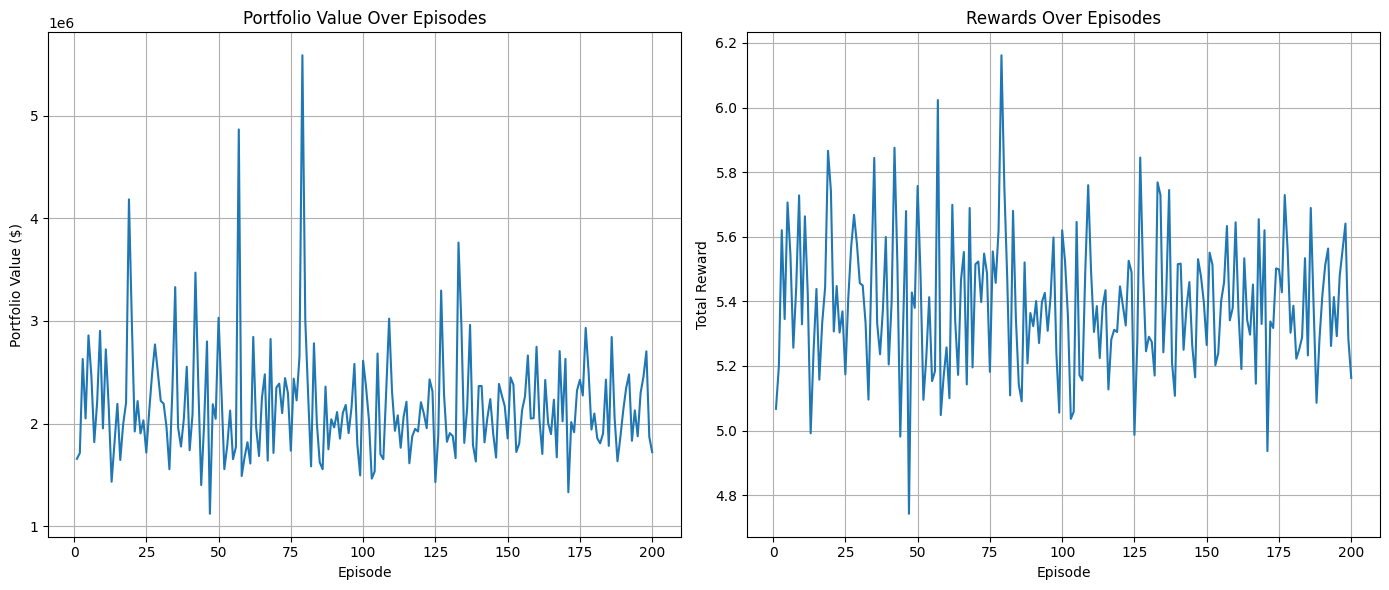

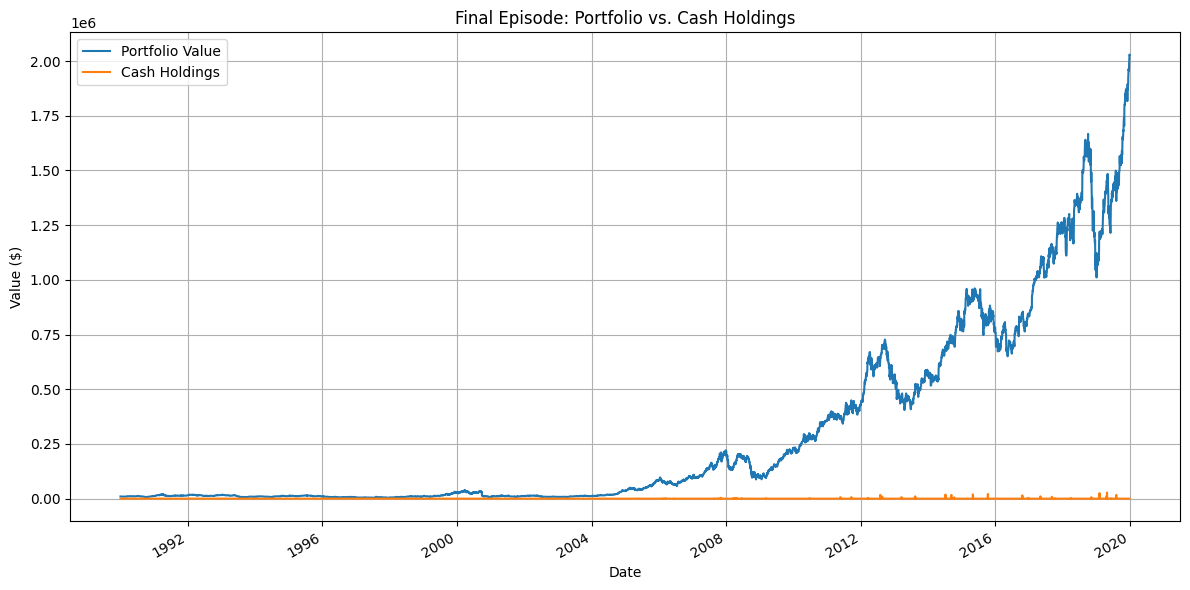

In [10]:
# --------------------------
# Plotting Section
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Episode-level performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(14, 6))

# Portfolio Value over Episodes
plt.subplot(1, 2, 1)
plt.plot(range(1, len(portfolio_values) + 1), portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

# Rewards over Episodes
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Build a DataFrame for the final episode's daily values, indexed by real dates
dates = data.index[:len(daily_values)]
daily_df = pd.DataFrame({
    "Portfolio Value": daily_values,
    "Cash Holdings":   daily_cash
}, index=dates)

for j, ticker in enumerate(tickers):
    # extract the j-th holding from each day
    daily_df[ticker] = [day_holdings[j] for day_holdings in daily_stock]

# 3) Final Episode: Portfolio vs. Cash Holdings
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[["Portfolio Value", "Cash Holdings"]].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Value ($)",
    title="Final Episode: Portfolio vs. Cash Holdings"
)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()


In [11]:
spy = (
    yf.download("SPY",
                start=dates[0],
                end=dates[-1],
                auto_adjust=False)["Close"]
    .reindex(dates)     # align to your exact days
    .ffill().bfill()
)

[*********************100%***********************]  1 of 1 completed


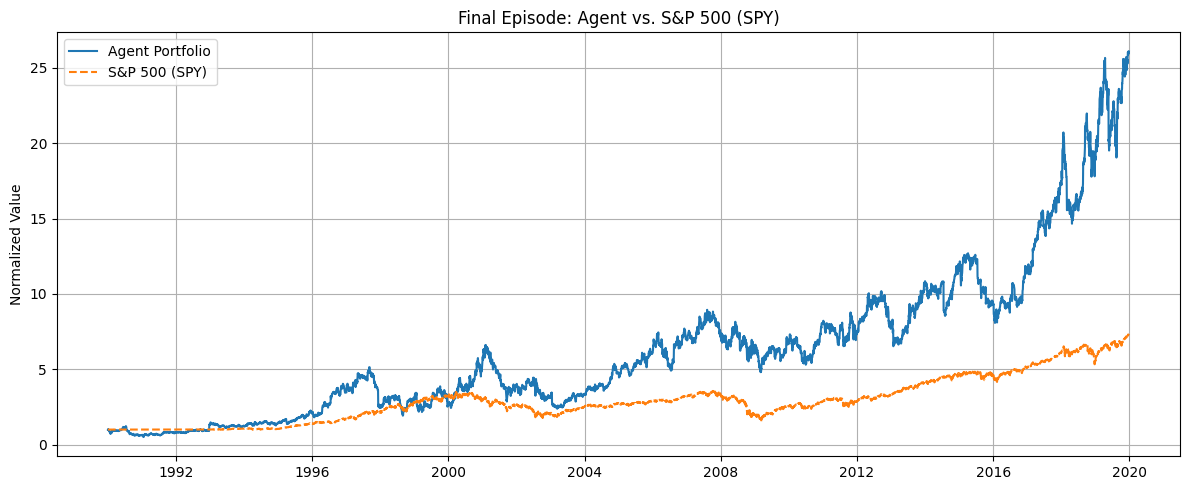

In [16]:
# normalize
norm_port = np.array(daily_values) / daily_values[0]
norm_spy  = spy.values       / spy.values[0]

# plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, norm_port, label="Agent Portfolio")
ax.plot(dates, norm_spy,  "--", label="S&P 500 (SPY)")
ax.set_title("Final Episode: Agent vs. S&P 500 (SPY)")
ax.set_ylabel("Normalized Value")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

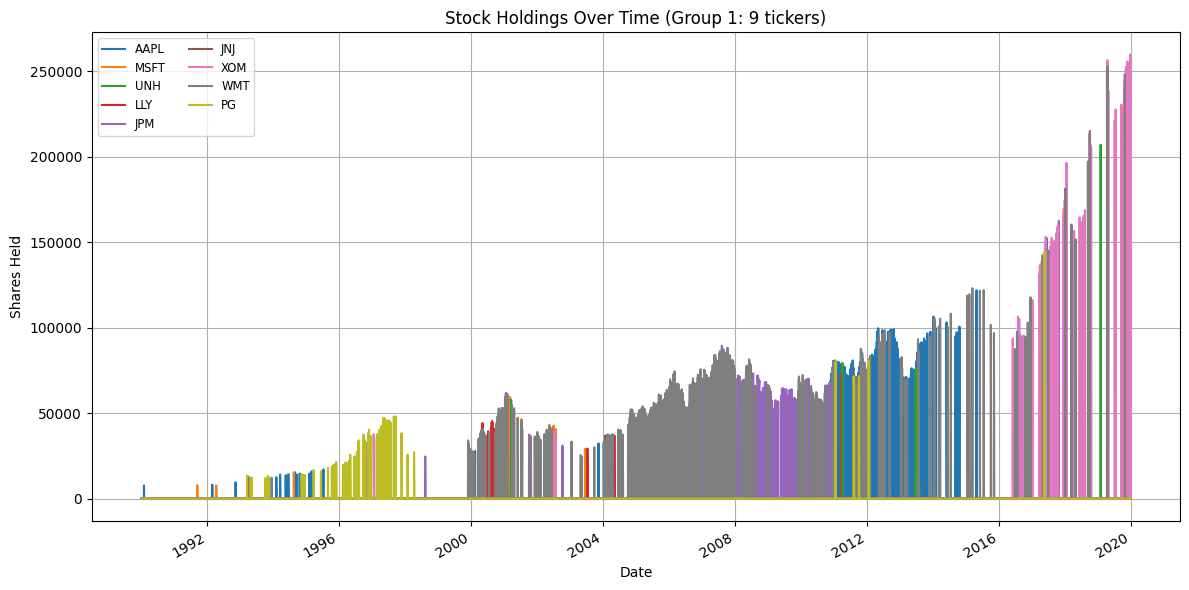

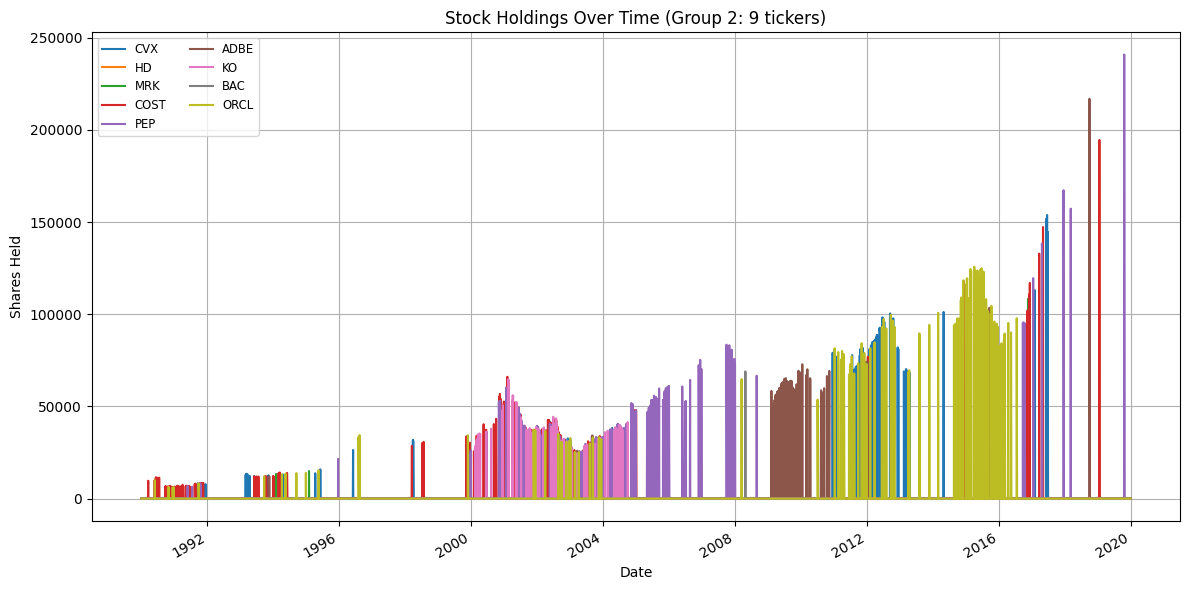

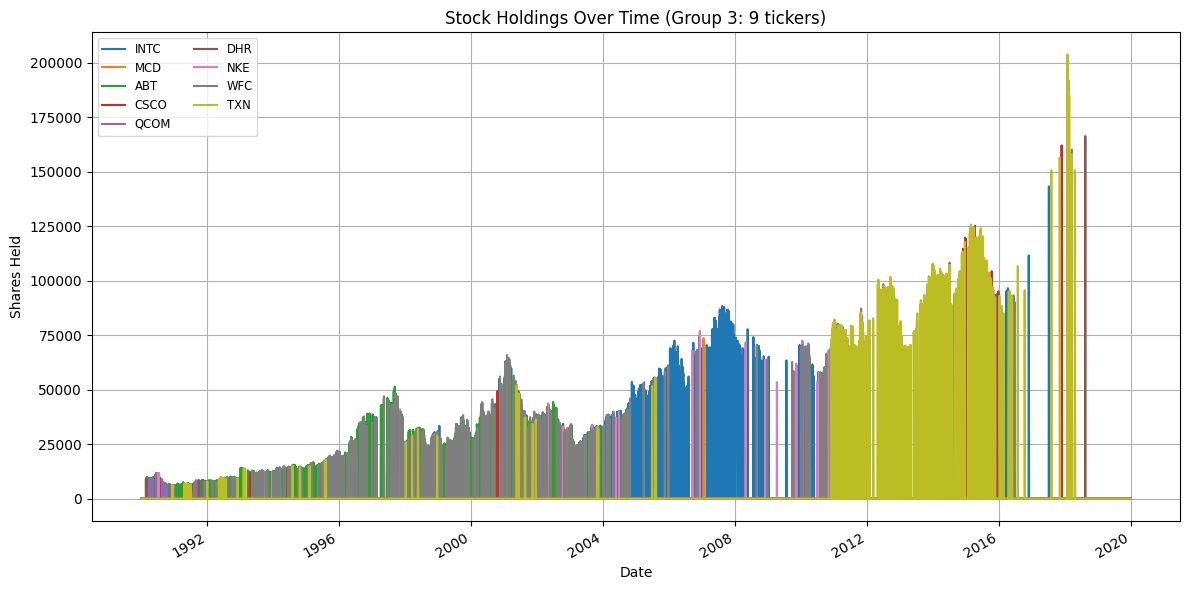

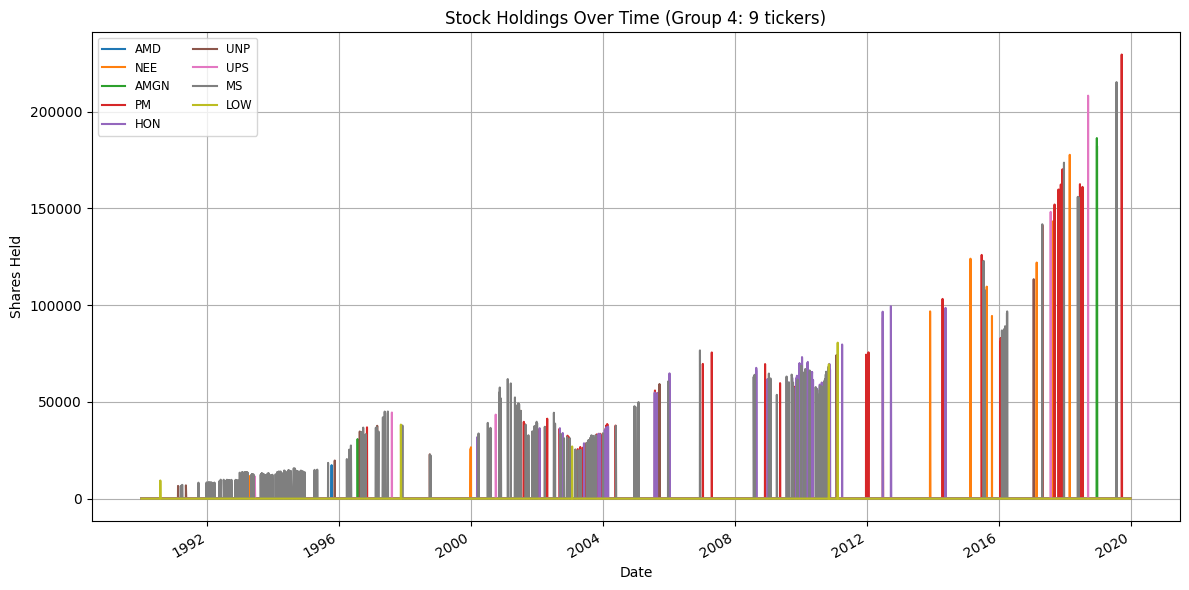

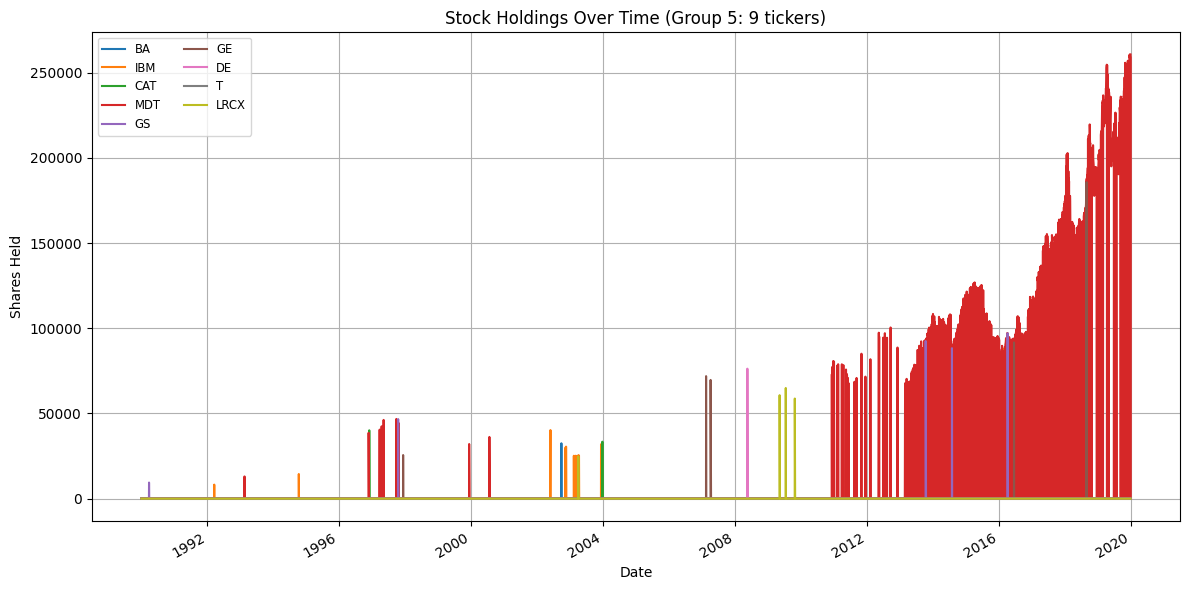

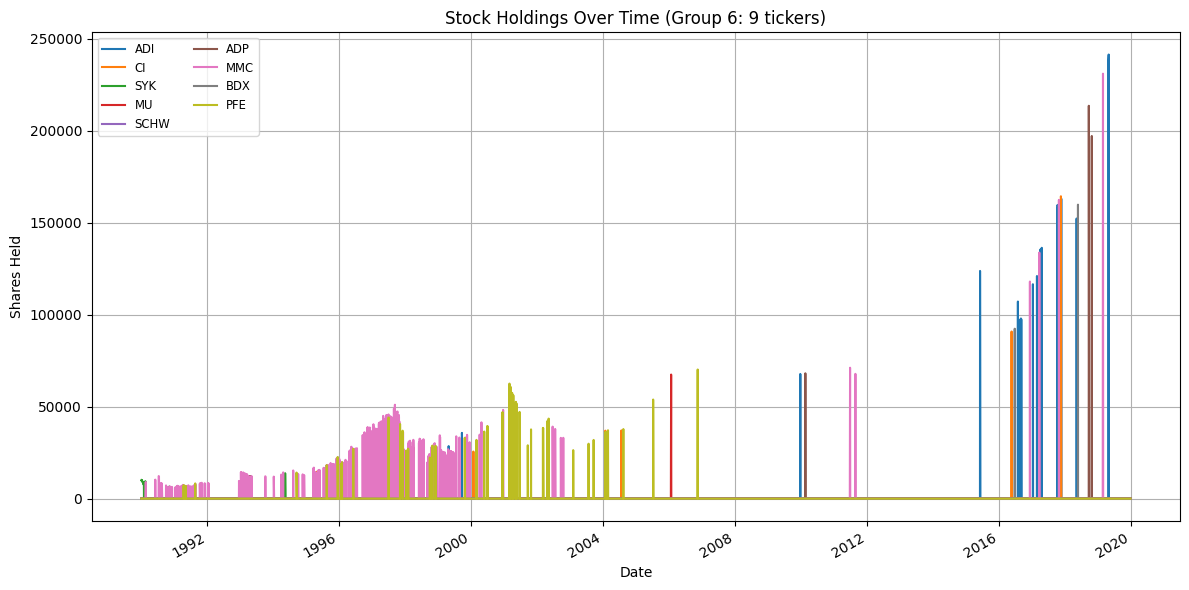

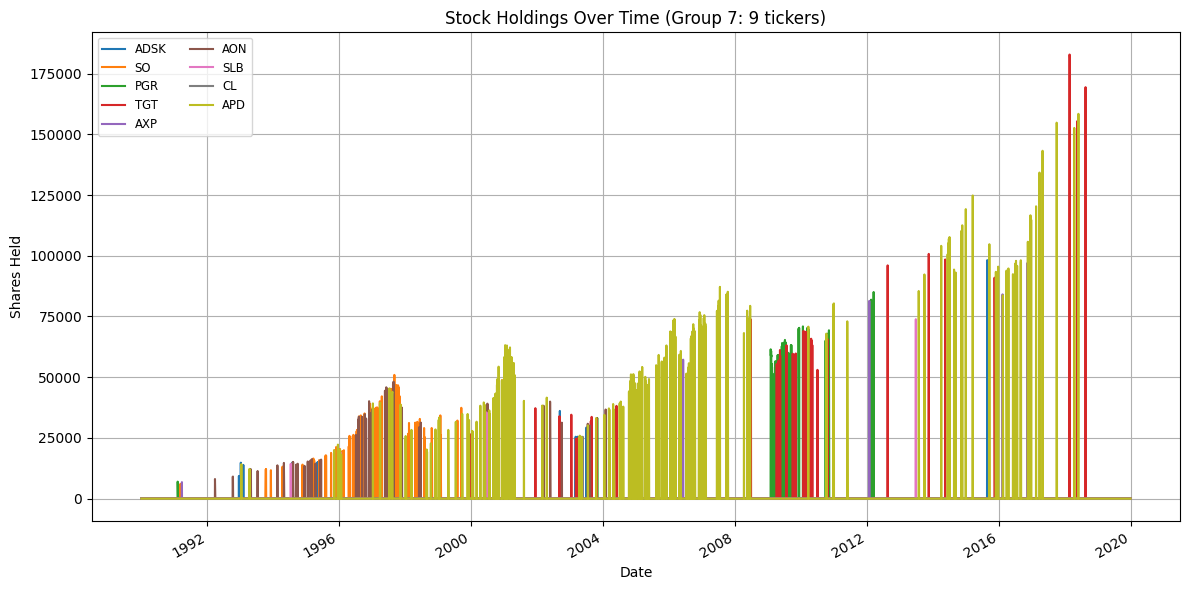

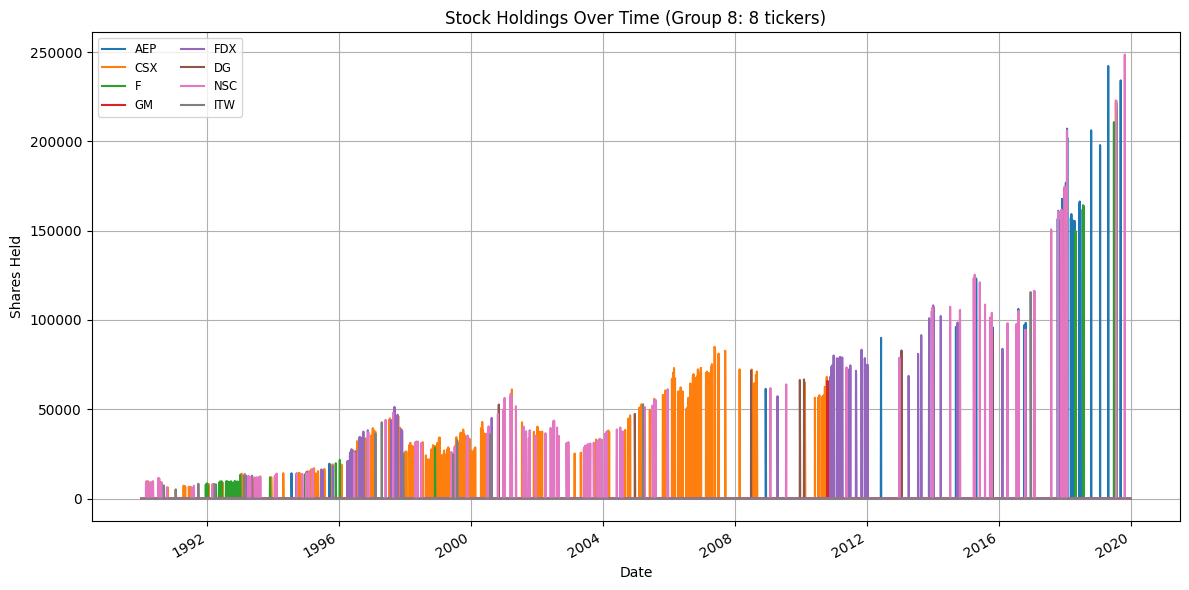

In [17]:
tickers_list     = tickers
num_plots        = 8
tickers_per_plot = int(np.ceil(len(tickers_list) / num_plots))

for i in range(num_plots):
    start_i = i * tickers_per_plot
    end_i   = start_i + tickers_per_plot
    subset  = tickers_list[start_i:end_i]
    if not subset:
        continue

    fig, ax = plt.subplots(figsize=(12, 6))
    daily_df[subset].plot(ax=ax)

    ax.set(
        xlabel="Date",
        ylabel="Shares Held",
        title=f"Stock Holdings Over Time (Group {i+1}: {len(subset)} tickers)"
    )
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.legend(loc="upper left", ncol=2, fontsize="small")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

## **Evaluation**

In [13]:
extra_test_vals = ["ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", 
 "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"]

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed
/scratch/4615043.1.l40s/ipykernel_518480/3119021002.py:191: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 42.46%
Benchmark (S&P500) Return: 65.80%


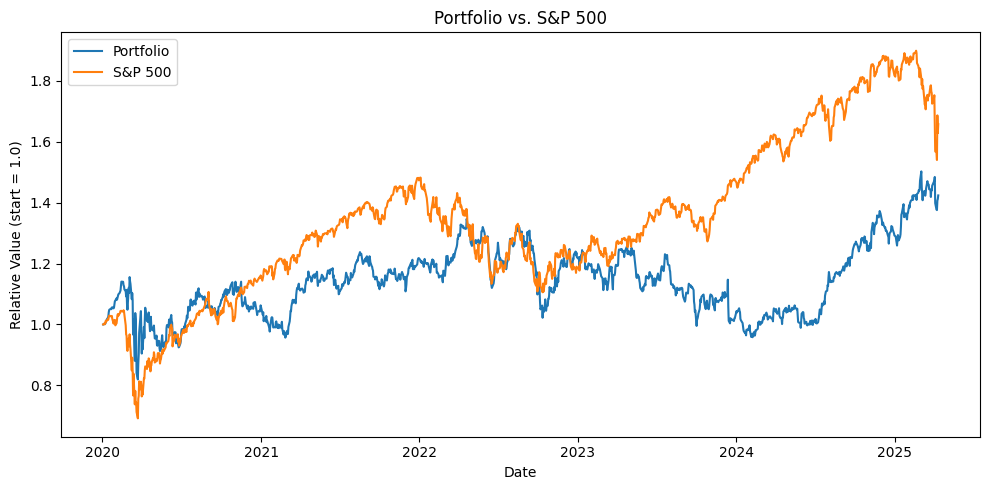

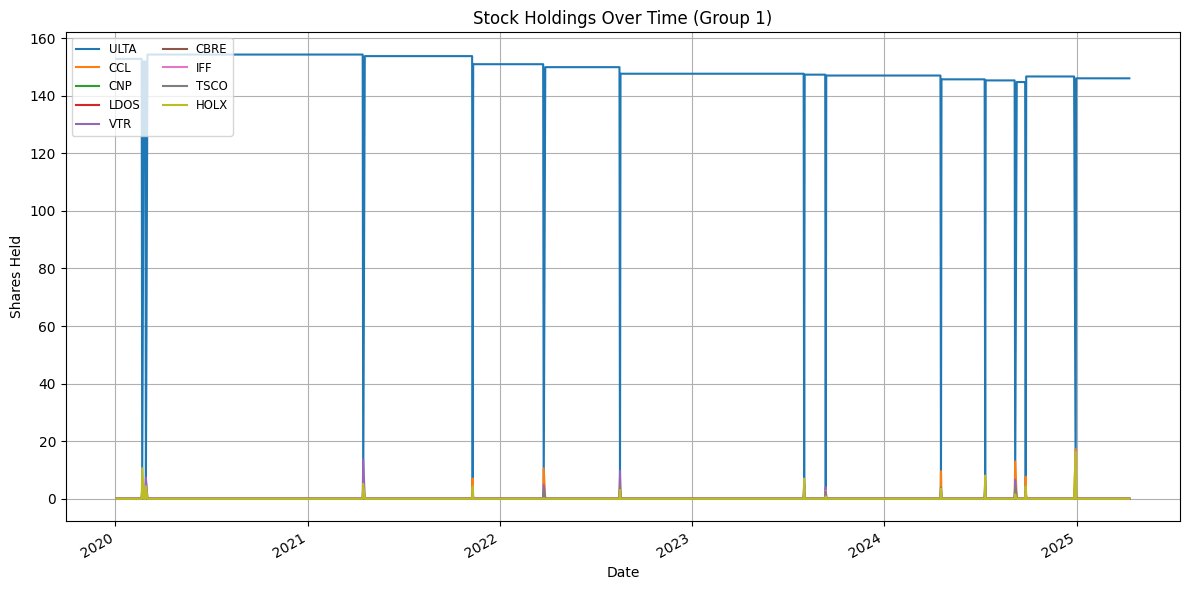

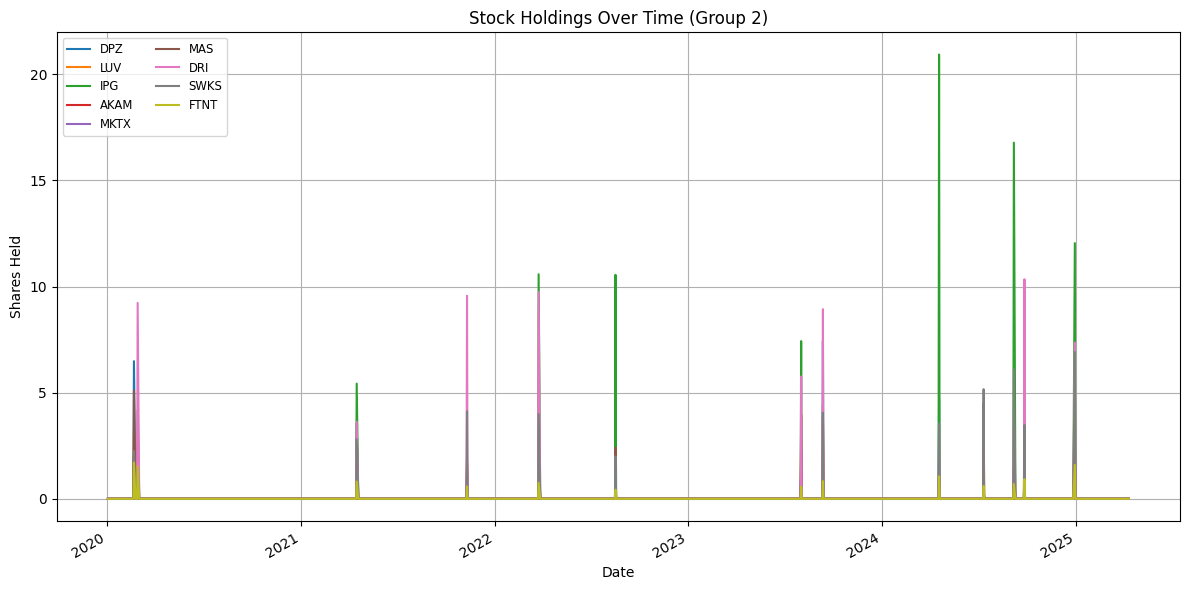

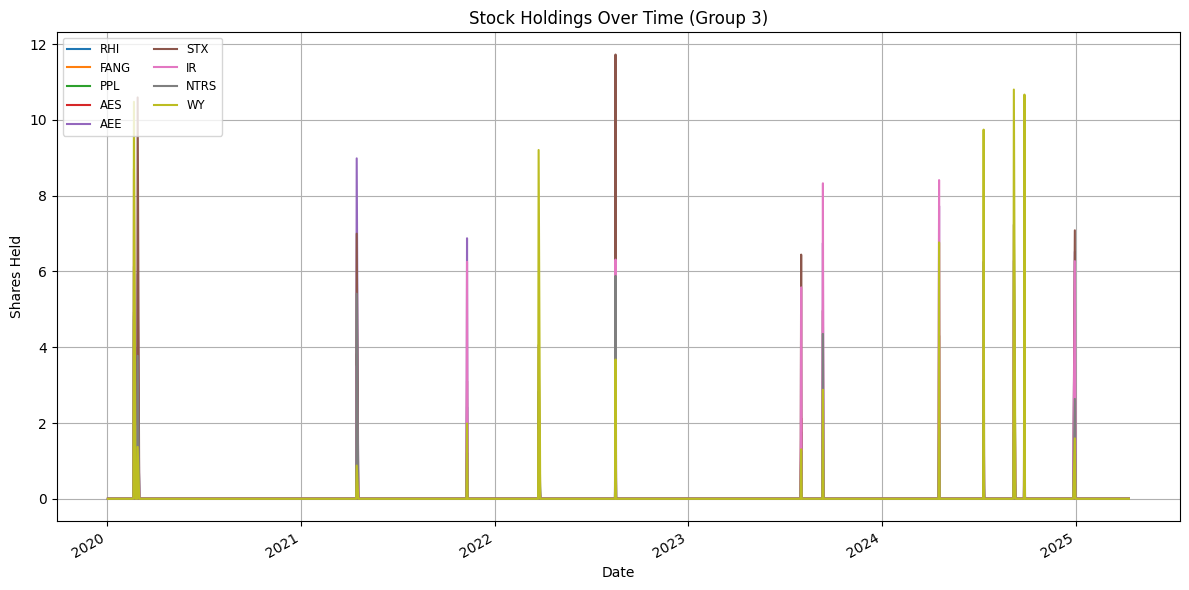

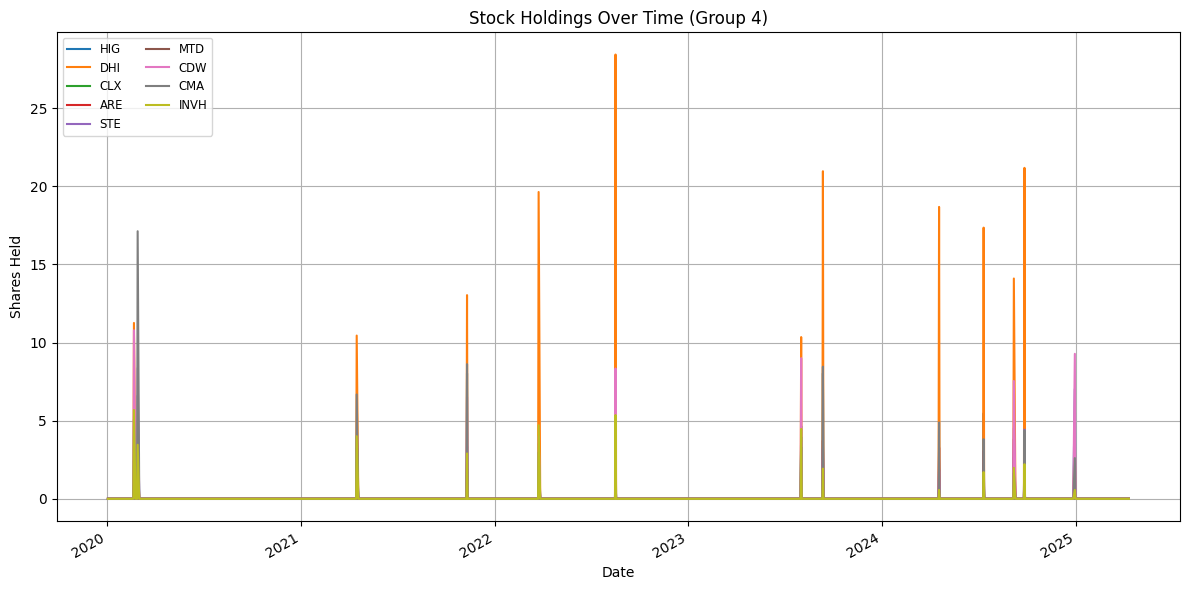

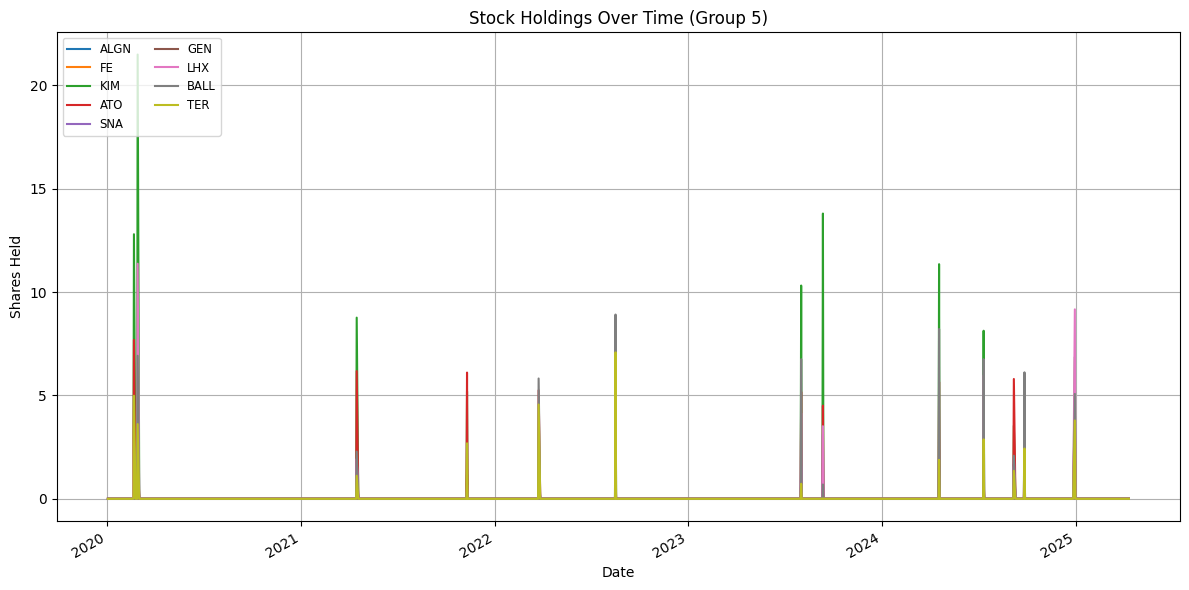

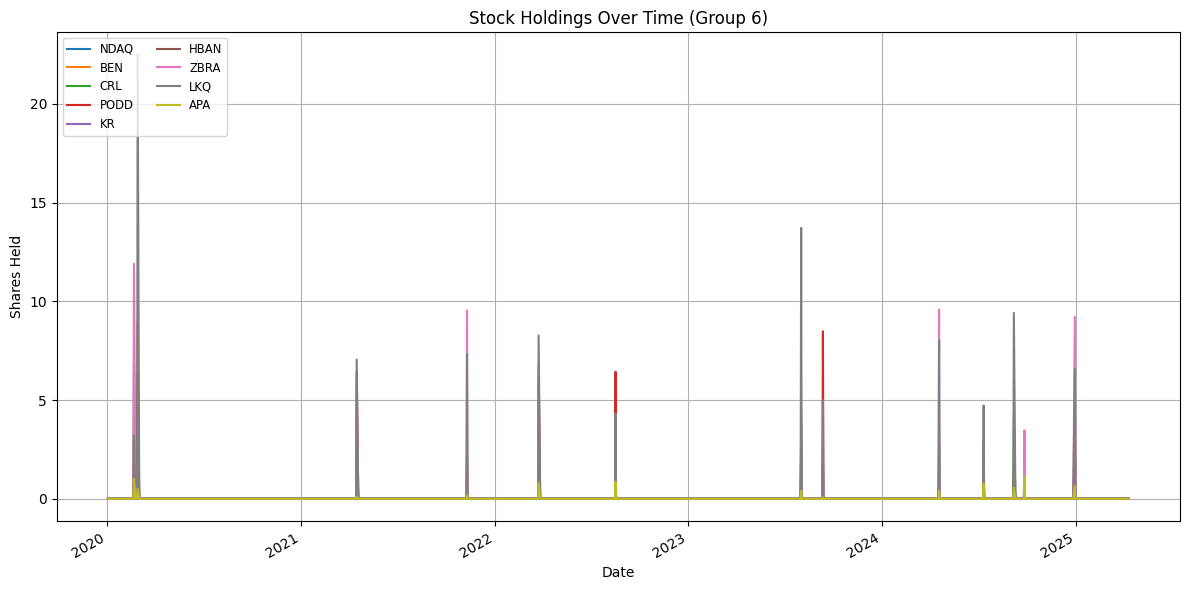

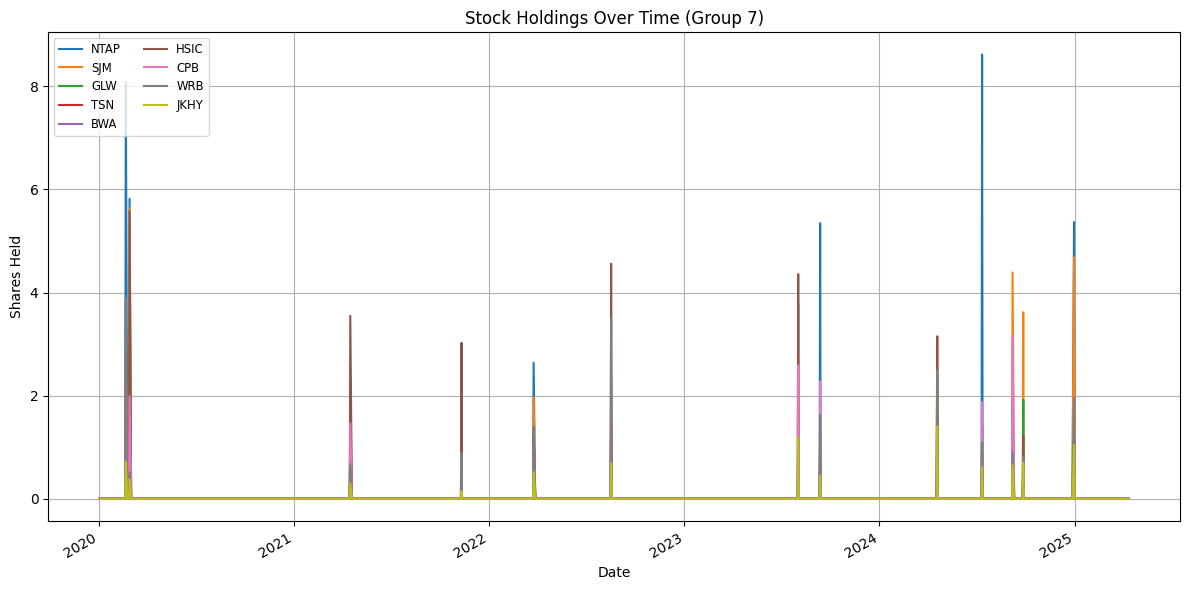

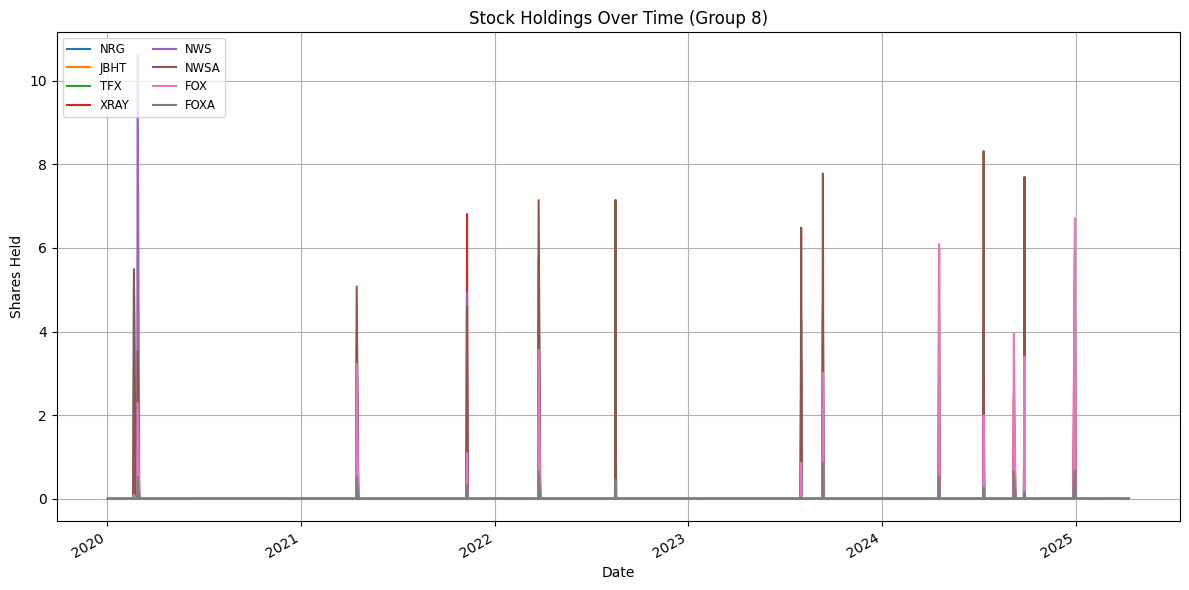

In [14]:
import gym
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from gym import spaces

# ------------------------------------------------------------------------
# Full evaluate_agent with individual-holdings plots (8 panels)
# ------------------------------------------------------------------------
def evaluate_agent(agent,
                   tickers,
                   start_date='2020-01-01',
                   end_date=None,
                   initial_cash=10_000,
                   transaction_cost=1e-5,
                   device=None):
    # --------------------------------------------------------------------
    # 1) Download and prepare market data (prices & S&P500)
    # --------------------------------------------------------------------
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    prices = price_df.values.astype(np.float32)
    dates  = price_df.index

    snp_series = yf.download(
        '^GSPC',
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    snp_vals = snp_series.values.astype(np.float32)

    # --------------------------------------------------------------------
    # 2) Assume these arrays & stats were computed during training:
    #    divs_arr, vols_arr, irate_arr,
    #    mu_price, std_price,
    #    mu_div,   std_div,
    #    mu_vol,   std_vol,
    #    mu_ir,    std_ir
    # --------------------------------------------------------------------

    class EvalEnv(gym.Env):
        def __init__(self, prices, divs, vols, irate, snp500,
                     initial_cash=10_000, transaction_cost=1e-5):
            super().__init__()
            self.prices_raw       = prices
            self.divs_raw         = divs
            self.vols_raw         = vols
            self.irate_raw        = irate
            self.snp500           = snp500[: prices.shape[0]]
            self.T, self.N        = prices.shape
            self.initial_cash     = initial_cash
            self.transaction_cost = transaction_cost

            # normalization stats from training
            self.mu_p, self.sd_p = mu_price, std_price
            self.mu_d, self.sd_d = mu_div,   std_div
            self.mu_v, self.sd_v = mu_vol,   std_vol
            self.mu_i, self.sd_i = mu_ir,    std_ir

            self.action_space = spaces.Box(
                low=0, high=1, shape=(self.N + 1,), dtype=np.float32
            )
            obs_dim = self.N*3 + self.N + 1 + 1
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
            )

        def reset(self):
            self.current_step = 0
            self.cash         = float(self.initial_cash)
            self.holdings     = np.zeros(self.N, dtype=np.float32)
            return self._get_obs()

        def _get_obs(self):
            t = self.current_step
            p = (self.prices_raw[t] - self.mu_p) / self.sd_p
            d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
            v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
            i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
            return np.concatenate([
                p, d, v,
                self.holdings,
                [self.cash],
                [i]
            ]).astype(np.float32)

        def step(self, action):
            # terminal check
            if self.current_step >= self.T - 1:
                return self._get_obs(), 0.0, True, {}

            # normalize & clip action
            action = np.clip(action, 1e-6, None)
            total  = action.sum()
            if total <= 0 or np.isnan(total):
                action = np.zeros_like(action)
                action[-1] = 1.0
            else:
                action = action / total

            prices     = np.clip(self.prices_raw[self.current_step], 1e-3, None)
            stock_vals = self.holdings * prices
            tot_value  = stock_vals.sum() + self.cash

            # compute targets
            target_stock_vals = action[:-1] * tot_value
            target_cash       = action[-1]  * tot_value
            new_holdings      = target_stock_vals / prices

            # transaction cost
            trades   = np.abs(new_holdings - self.holdings) * prices
            turnover = trades.sum()
            cost     = self.transaction_cost * turnover

            # next step prices
            next_prices = np.clip(
                self.prices_raw[self.current_step + 1], 1e-3, None
            )
            next_stock_value = (new_holdings * next_prices).sum()
            next_tot_value   = next_stock_value + target_cash - cost

            # handle numerical issues
            if np.isnan(next_tot_value) or np.isinf(next_tot_value):
                return self._get_obs(), -1.0, True, {}

            # reward = (portfolio return) - (S&P return)
            port_ret = next_tot_value / tot_value - 1
            snp_ret  = (
                self.snp500[self.current_step + 1]
                / self.snp500[self.current_step]
                - 1
            )
            reward = port_ret - snp_ret

            # state update
            self.holdings     = new_holdings
            self.cash         = target_cash - cost
            self.current_step += 1
            done = (self.current_step >= self.T - 1)

            return self._get_obs(), reward, done, {}

    # --------------------------------------------------------------------
    # 3) Instantiate env and run deterministic evaluation
    # --------------------------------------------------------------------
    env = EvalEnv(
        prices, divs_arr, vols_arr, irate_arr, snp_vals,
        initial_cash=initial_cash,
        transaction_cost=transaction_cost
    )

    state = env.reset()
    agent.epsilon = agent.epsilon_min

    portf_vals, bench_vals = [], []
    holdings_history = []
    dates_hist      = []

    # --------------------------------------------------------------------
    # 4) Evaluation loop with history recording
    # --------------------------------------------------------------------
    while True:
        action = dqn_agent.select_action(state)
        next_state, _, done, _ = env.step(action)
        state = next_state

        t = env.current_step
        dates_hist.append(dates[t])
        portf_vals.append(env.cash + (env.holdings * env.prices_raw[t]).sum())
        bench_vals.append(env.snp500[t])
        holdings_history.append(env.holdings.copy())

        if done:
            break

    # --------------------------------------------------------------------
    # 5) Print returns
    # --------------------------------------------------------------------
    cum_return   = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")

    # --------------------------------------------------------------------
    # 6) Normalize & plot Portfolio vs. S&P500
    # --------------------------------------------------------------------
    portf_arr  = np.array(portf_vals, dtype=np.float32)
    bench_arr  = np.array(bench_vals, dtype=np.float32)
    norm_pf    = portf_arr / portf_arr[0]
    norm_bench = bench_arr / bench_arr[0]
    xs = dates[1 : 1 + len(norm_pf)]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, norm_pf,    label='Portfolio')
    plt.plot(xs, norm_bench, label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Relative Value (start = 1.0)')
    plt.title('Portfolio vs. S&P 500')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 7) Build holdings DataFrame
    # --------------------------------------------------------------------
    holdings_arr = np.vstack(holdings_history)
    holdings_df  = pd.DataFrame(
        holdings_arr,
        index=pd.to_datetime(dates_hist),
        columns=tickers
    )

    # --------------------------------------------------------------------
    # 8) Plot individual holdings in 8 panels
    # --------------------------------------------------------------------
    num_plots        = 8
    tickers_per_plot = int(np.ceil(len(tickers) / num_plots))

    for i in range(num_plots):
        start_i = i * tickers_per_plot
        end_i   = start_i + tickers_per_plot
        subset  = tickers[start_i:end_i]
        if not subset:
            continue

        fig, ax = plt.subplots(figsize=(12, 6))
        holdings_df[subset].plot(ax=ax)

        ax.set(
            xlabel="Date",
            ylabel="Shares Held",
            title=f"Stock Holdings Over Time (Group {i+1})"
        )
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend(loc="upper left", ncol=2, fontsize="small")
        ax.grid(True)

        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------------
if __name__ == "__main__":
    swag = evaluate_agent(
        dqn_agent,
        extra_test_vals,
        start_date='2020-01-01',
        end_date='2025-04-14',
        initial_cash=10000,
        transaction_cost=1e-5,
        device=device
    )